Geladene Daten: 229 Zeilen

=== ZEITLICHER SPLIT ===
Train: 172 | Val: 18 | Test: 9
Verwendete Features (6): ['signed_amount', 'tx_hour', 'tx_weekday', 'price_before', 'vol_before', 'vwap_before']

=== EVALUATION ===
Model MAE:      0.0529
Baseline MAE:   0.2442
Std (Train):    0.2892
✅ Modell besser als Durchschnitts-Baseline
✅ Modell besser als naive Streuung (MEI)

=== PRO AKTIE ===


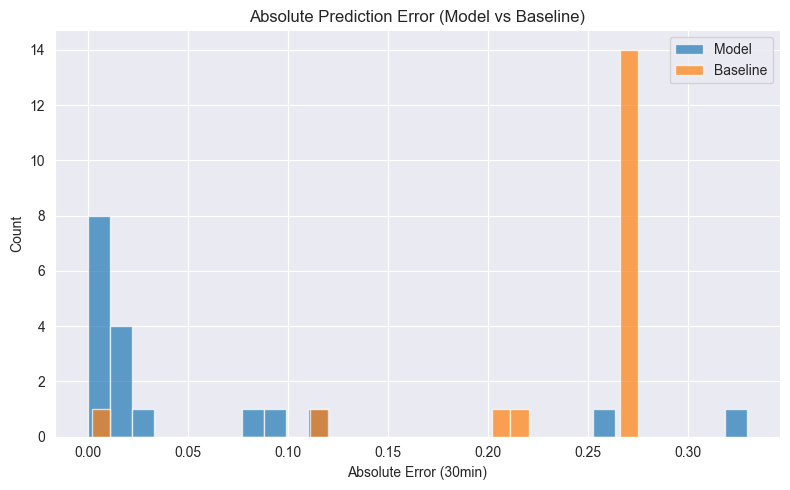

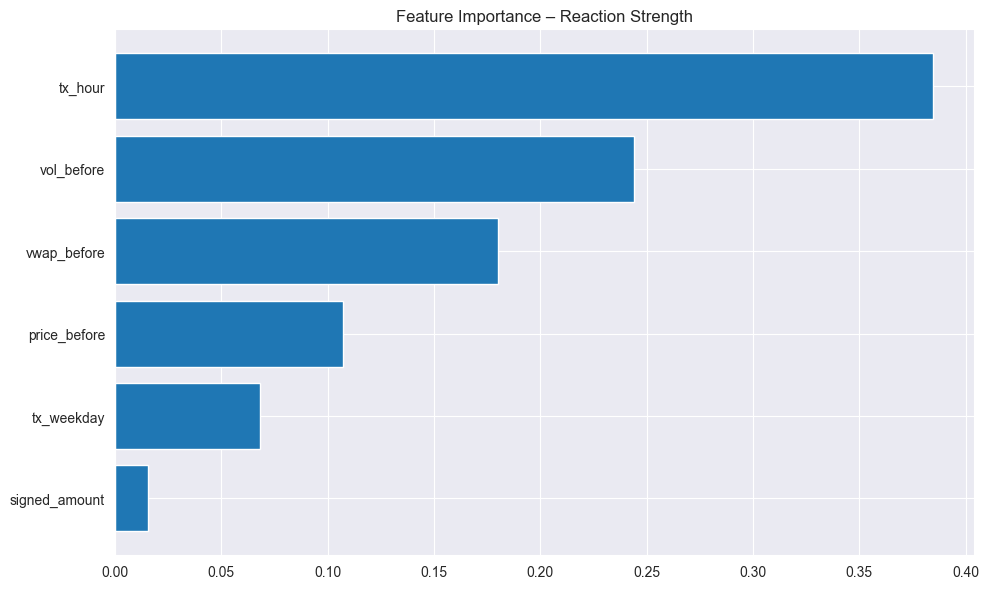


✅ Modell gespeichert


In [1]:
# 07_model_training_senator.py
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import joblib
import os

# =========================
# 1. Daten laden
# =========================
df = pd.read_parquet(
    r"C:\Users\User\PycharmProjects\Project-Trading\data\senator_stock_merged_fixed.parquet"
)
print(f"Geladene Daten: {len(df)} Zeilen")

df['TimeOfFiled'] = pd.to_datetime(df['TimeOfFiled'])

# =========================
# 2. TARGET: absolute Abweichung
# =========================
df['abs_change_pct'] = df['price_change_pct'].abs()
target = 'abs_change_pct'

# =========================
# 3. Zeitlicher Split
# =========================
train_mask = (df['TimeOfFiled'] >= '2022-01-01') & (df['TimeOfFiled'] <= '2024-12-31')
val_mask   = (df['TimeOfFiled'] >= '2025-01-01') & (df['TimeOfFiled'] <= '2025-03-31')
test_mask  = (df['TimeOfFiled'] >= '2025-04-01') & (df['TimeOfFiled'] <= '2025-06-30')

df_train = df[train_mask].copy()
df_val   = df[val_mask].copy()
df_test  = df[test_mask].copy()

print("\n=== ZEITLICHER SPLIT ===")
print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

# =========================
# 4. Features
# =========================
features = [
    'signed_amount', 'relative_trade_size',
    'tx_hour', 'tx_weekday',
    'price_before', 'vol_before', 'vwap_before',
    'ema_5', 'ema_15', 'ema_30',
    'price_slope_15'
]

features = [f for f in features if f in df.columns]
print(f"Verwendete Features ({len(features)}): {features}")

X_train = df_train[features]
y_train = df_train[target]

X_val = df_val[features]
y_val = df_val[target]

# =========================
# 5. Modell
# =========================
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# =========================
# 6. Vorhersagen
# =========================
val_pred = model.predict(X_val)

# =========================
# 7. Evaluation (FEEDBACK-KONFORM)
# =========================
model_mae = mean_absolute_error(y_val, val_pred)

# Baseline = durchschnittliche absolute Abweichung
baseline_value = y_train.mean()
baseline_pred = np.full_like(y_val, baseline_value)
baseline_mae = mean_absolute_error(y_val, baseline_pred)

# Streuung (MEI-Referenz)
std_abs = y_train.std()

print("\n=== EVALUATION ===")
print(f"Model MAE:      {model_mae:.4f}")
print(f"Baseline MAE:   {baseline_mae:.4f}")
print(f"Std (Train):    {std_abs:.4f}")

if model_mae < baseline_mae:
    print("✅ Modell besser als Durchschnitts-Baseline")
else:
    print("⚠️ Modell NICHT besser als Baseline")

if model_mae < std_abs:
    print("✅ Modell besser als naive Streuung (MEI)")
else:
    print("⚠️ Modell NICHT besser als Streuung")

# =========================
# 8. Pro-Aktie Auswertung
# =========================
print("\n=== PRO AKTIE ===")
for ticker in df_val['Ticker'].unique():
    sub = df_val[df_val['Ticker'] == ticker]
    if len(sub) < 10:
        continue

    pred = model.predict(sub[features])
    mae_model = mean_absolute_error(sub[target], pred)
    mae_base = mean_absolute_error(
        sub[target],
        np.full_like(sub[target], baseline_value)
    )

    print(f"{ticker}: Model MAE={mae_model:.4f} | Baseline MAE={mae_base:.4f}")


# 9. Plot: Absolute Fehler

os.makedirs('images', exist_ok=True)

plt.figure(figsize=(8, 5))
plt.hist(np.abs(y_val - val_pred), bins=30, alpha=0.7, label='Model')
plt.hist(np.abs(y_val - baseline_pred), bins=30, alpha=0.7, label='Baseline')
plt.legend()
plt.title('Absolute Prediction Error (Model vs Baseline)')
plt.xlabel('Absolute Error (30min)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/07_abs_error_comparison.png', dpi=150)
plt.show()


# 10. Feature Importance

fi = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(fi['feature'], fi['importance'])
plt.title('Feature Importance – Reaction Strength')
plt.tight_layout()
plt.savefig('images/07_feature_importance.png', dpi=150)
plt.show()


# 11. Modell speichern

os.makedirs('models', exist_ok=True)
joblib.dump(model, 'models/senator_randomforest.pkl')
print("\n Modell gespeichert")
